In [1]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, Layer

from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from progressbar import ProgressBar
from scipy.io import loadmat, savemat
from matplotlib import pyplot as plt

%matplotlib notebook
from ipywidgets import *
plt.rcParams.update({'font.size': 16})

In [2]:
# loss function and new custom layer to give mean and standard deviation
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]
    
# Function to seperate the time series into samples for next step prediction. "n_steps_in" is the lookback window
def splitsequence(sequence, n_steps_in, n_steps_out):
    X, Y = list(), list()
    for i in range(len(sequence)):
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out
        if out_end_idx > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx:out_end_idx]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

In [3]:
n_steps_in, n_steps_out = 10, 1  #lookback window and one step prediction into future
n_features=1  # just one feature - capacity                   

loaddata=loadmat('../Datasets/Training - 169 LFP.mat')
battery_HI = loaddata['ydata']
nbatteries = np.shape(battery_HI)[1]

bid = 0
raw_seq = 1 - battery_HI[0,bid]  # we do 1-capacity to make HI increasing to EOL
X, Y = splitsequence(raw_seq[0,:], n_steps_in, n_steps_out)
X = X.reshape((X.shape[0], X.shape[1], n_features))   #samples of length n_steps_in
Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))   #next step prediction value
allX=X    
allY=Y

for bid in range(1, nbatteries):
    raw_seq = 1-battery_HI[0,bid]
    X, Y = splitsequence(raw_seq[0,:], n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], n_features))   #samples of length n_steps_in
    Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))   #next step prediction value
    allX=np.concatenate((allX,X),axis=0)  #combine for all batteries
    allY=np.concatenate((allY,Y),axis=0)  #combine for all batteries
allY=allY.reshape(np.shape(allY)[0],np.shape(allY)[1])   

In [4]:
print("(#samples, nlookback, nfeature):", np.shape(allX))

(#samples, nlookback, nfeature): (6822, 10, 1)


In [8]:
def create_trained_network(allX, allY, n_steps, n_features):
    inputs = Input(shape=(n_steps_in, n_features))
    x = LSTM(80, activation='tanh', return_sequences=False)(inputs)
    x = Dense(10, activation='tanh')(x) 
    mu, sigma = GaussianLayer(np.shape(allY)[1], name='main_output')(x)
    model = Model(inputs, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(allX, allY,shuffle=True, epochs=50)
    layer_name = 'main_output' # Where to extract the output from
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

prediction_fns = []
nmodels = 10
for i in range(nmodels):
    prediction_fns.append(create_trained_network(allX, allY, n_steps_in, n_features))

Train on 6822 samples
Epoch 1/50
6822/6822 [==============================] - 2s 281us/sample - loss: -0.3554
Epoch 2/50
6822/6822 [==============================] - 1s 123us/sample - loss: -1.9909
Epoch 3/50
6822/6822 [==============================] - 1s 122us/sample - loss: -3.1312
Epoch 4/50
6822/6822 [==============================] - 1s 117us/sample - loss: -3.6465
Epoch 5/50
6822/6822 [==============================] - 1s 118us/sample - loss: -3.8296
Epoch 6/50
6822/6822 [==============================] - 1s 112us/sample - loss: -4.0505
Epoch 7/50
6822/6822 [==============================] - 1s 115us/sample - loss: -4.1535
Epoch 8/50
6822/6822 [==============================] - 1s 126us/sample - loss: -4.3009
Epoch 9/50
6822/6822 [==============================] - 1s 117us/sample - loss: -4.4886
Epoch 10/50
6822/6822 [==============================] - 1s 118us/sample - loss: -4.6013
Epoch 11/50
6822/6822 [==============================] - 1s 120us/sample - loss: -4.7536
Epoch 12

6822/6822 [==============================] - 1s 112us/sample - loss: -5.0661
Epoch 43/50
6822/6822 [==============================] - 1s 113us/sample - loss: -5.0416
Epoch 44/50
6822/6822 [==============================] - 1s 111us/sample - loss: -4.9988
Epoch 45/50
6822/6822 [==============================] - 1s 112us/sample - loss: -5.1032
Epoch 46/50
6822/6822 [==============================] - 1s 112us/sample - loss: -4.9966
Epoch 47/50
6822/6822 [==============================] - 1s 113us/sample - loss: -5.1106
Epoch 48/50
6822/6822 [==============================] - 1s 113us/sample - loss: -5.0920
Epoch 49/50
6822/6822 [==============================] - 1s 114us/sample - loss: -5.0590
Epoch 50/50
6822/6822 [==============================] - 1s 112us/sample - loss: -5.0860
Train on 6822 samples
Epoch 1/50
6822/6822 [==============================] - 2s 299us/sample - loss: -1.8618
Epoch 2/50
6822/6822 [==============================] - 1s 112us/sample - loss: -3.1132
Epoch 3/50
68

6822/6822 [==============================] - 1s 115us/sample - loss: -5.0050
Epoch 34/50
6822/6822 [==============================] - 1s 113us/sample - loss: -4.9933
Epoch 35/50
6822/6822 [==============================] - 1s 114us/sample - loss: -5.0353
Epoch 36/50
6822/6822 [==============================] - 1s 112us/sample - loss: -5.0534
Epoch 37/50
6822/6822 [==============================] - 1s 113us/sample - loss: -4.4648
Epoch 38/50
6822/6822 [==============================] - 1s 114us/sample - loss: -5.0479
Epoch 39/50
6822/6822 [==============================] - 1s 113us/sample - loss: -5.0252
Epoch 40/50
6822/6822 [==============================] - 1s 114us/sample - loss: -5.0298
Epoch 41/50
6822/6822 [==============================] - 1s 118us/sample - loss: -5.0197
Epoch 42/50
6822/6822 [==============================] - 1s 120us/sample - loss: -4.9212
Epoch 43/50
6822/6822 [==============================] - 1s 113us/sample - loss: -5.0142
Epoch 44/50
6822/6822 [==========

6822/6822 [==============================] - 1s 119us/sample - loss: -4.9119
Epoch 25/50
6822/6822 [==============================] - 1s 119us/sample - loss: -5.0039
Epoch 26/50
6822/6822 [==============================] - 1s 115us/sample - loss: -4.5614
Epoch 27/50
6822/6822 [==============================] - 1s 119us/sample - loss: -5.0799
Epoch 28/50
6822/6822 [==============================] - 1s 114us/sample - loss: -5.0933
Epoch 29/50
6822/6822 [==============================] - 1s 124us/sample - loss: -5.0083
Epoch 30/50
6822/6822 [==============================] - 1s 121us/sample - loss: -5.1373
Epoch 31/50
6822/6822 [==============================] - 1s 112us/sample - loss: -4.1547
Epoch 32/50
6822/6822 [==============================] - 1s 118us/sample - loss: -5.0859
Epoch 33/50
6822/6822 [==============================] - 1s 127us/sample - loss: -5.0075
Epoch 34/50
6822/6822 [==============================] - 1s 114us/sample - loss: -5.0276
Epoch 35/50
6822/6822 [==========

6822/6822 [==============================] - 1s 120us/sample - loss: -4.9620
Epoch 16/50
6822/6822 [==============================] - 1s 116us/sample - loss: -5.1317
Epoch 17/50
6822/6822 [==============================] - 1s 125us/sample - loss: -5.1083
Epoch 18/50
6822/6822 [==============================] - 1s 125us/sample - loss: -4.9358
Epoch 19/50
6822/6822 [==============================] - 1s 122us/sample - loss: -4.7653
Epoch 20/50
6822/6822 [==============================] - 1s 118us/sample - loss: -5.1225
Epoch 21/50
6822/6822 [==============================] - 1s 121us/sample - loss: -5.1254
Epoch 22/50
6822/6822 [==============================] - 1s 118us/sample - loss: -5.0624
Epoch 23/50
6822/6822 [==============================] - 1s 117us/sample - loss: -5.0944
Epoch 24/50
6822/6822 [==============================] - 1s 121us/sample - loss: -5.0409
Epoch 25/50
6822/6822 [==============================] - 1s 120us/sample - loss: -5.2268
Epoch 26/50
6822/6822 [==========

6822/6822 [==============================] - 1s 116us/sample - loss: -4.4483
Epoch 7/50
6822/6822 [==============================] - 1s 116us/sample - loss: -4.5507
Epoch 8/50
6822/6822 [==============================] - 1s 117us/sample - loss: -4.7737
Epoch 9/50
6822/6822 [==============================] - 1s 123us/sample - loss: -4.7924
Epoch 10/50
6822/6822 [==============================] - 1s 118us/sample - loss: -4.8796
Epoch 11/50
6822/6822 [==============================] - 1s 116us/sample - loss: -4.9447
Epoch 12/50
6822/6822 [==============================] - 1s 115us/sample - loss: -4.8791
Epoch 13/50
6822/6822 [==============================] - 1s 116us/sample - loss: -5.0003
Epoch 14/50
6822/6822 [==============================] - 1s 117us/sample - loss: -4.8564
Epoch 15/50
6822/6822 [==============================] - 1s 114us/sample - loss: -4.8991
Epoch 16/50
6822/6822 [==============================] - 1s 117us/sample - loss: -5.0281
Epoch 17/50
6822/6822 [=============

In [9]:
# Write a function which provides RUL
def pred_model(myXinitial, predf, n_steps, n_features, cutoff):
    # myXinitial - the recent nlookback predictions
    # predf - prediction function
    preds, sigmas = [], []
    RUL=0
    myHI=0
    x_input=np.copy(myXinitial)
    while myHI<cutoff:
        x_input=x_input.reshape((1,n_steps,n_features))
        mu_sigma = [(predf([x_input])[0][0], \
                     predf([x_input])[1][0])]
        out_mus = [i for i,j in mu_sigma] # mean forecast
        out_sigmas = [j for i,j in mu_sigma] # standard deviation
        preds.append(out_mus[0])
        sigmas.append(np.sqrt(out_sigmas[0]))
        yy=np.copy(out_mus)
        ytest=yy.reshape((1,1,n_features))
        XX=np.concatenate((x_input,ytest), axis=1)
        x_input=np.copy(XX[0,1:n_steps+1,:])
        myHI=out_mus[0][-1]
        RUL=RUL+1
        if RUL>300:  # break loop if forecast is not increasing - occurs when model predicts flat
            break
    predsarr=np.array(preds)
    sigmasarr=np.array(sigmas)
    return (predsarr,sigmasarr, RUL)

<IPython.core.display.Javascript object>


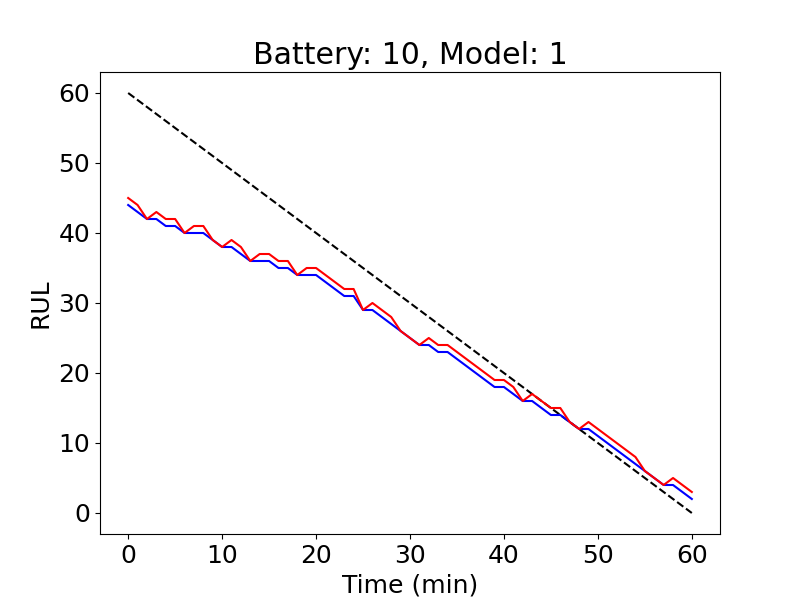

<IPython.core.display.Javascript object>


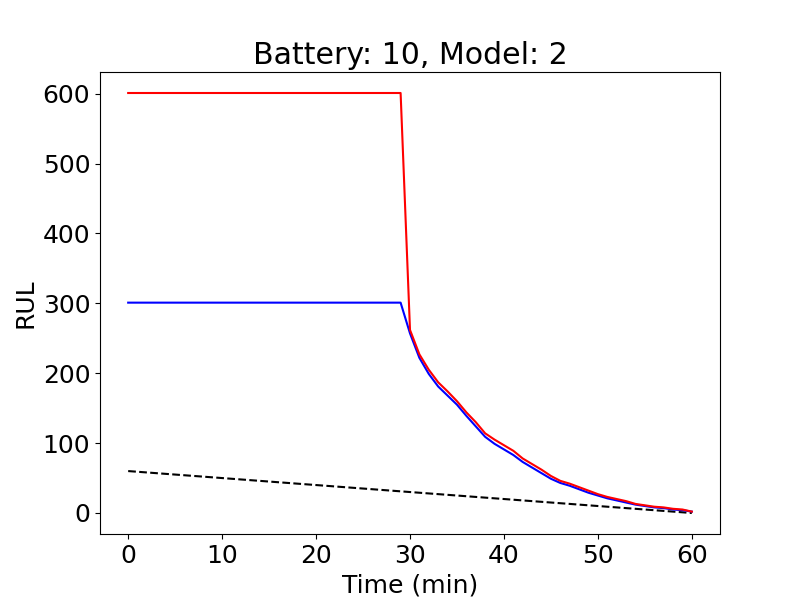

<IPython.core.display.Javascript object>


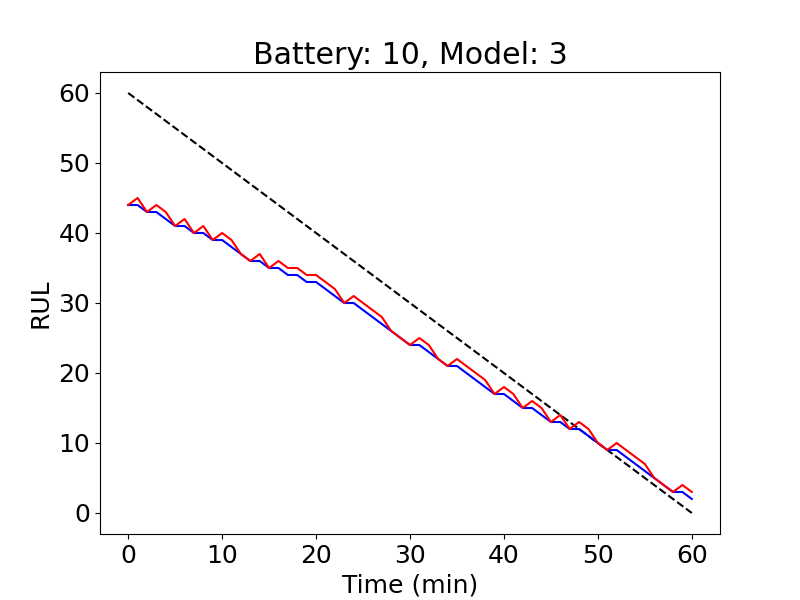

<IPython.core.display.Javascript object>


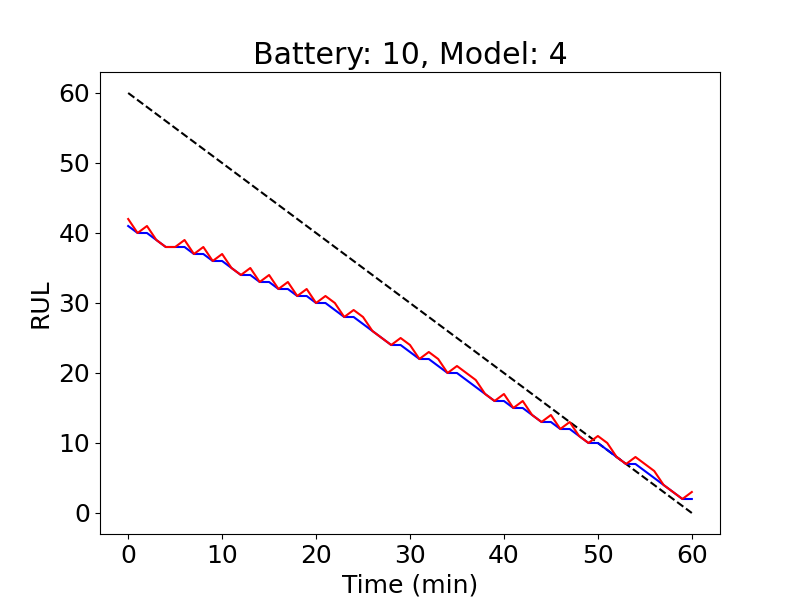

<IPython.core.display.Javascript object>


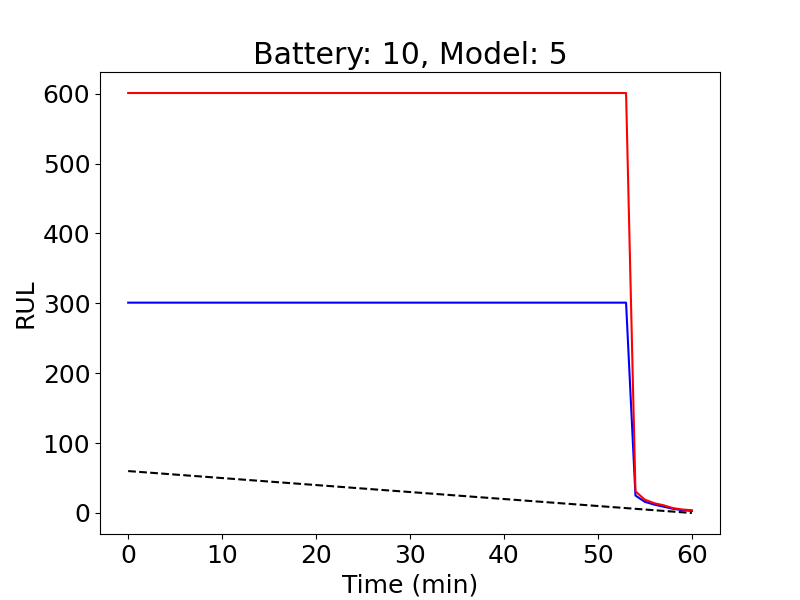

<IPython.core.display.Javascript object>


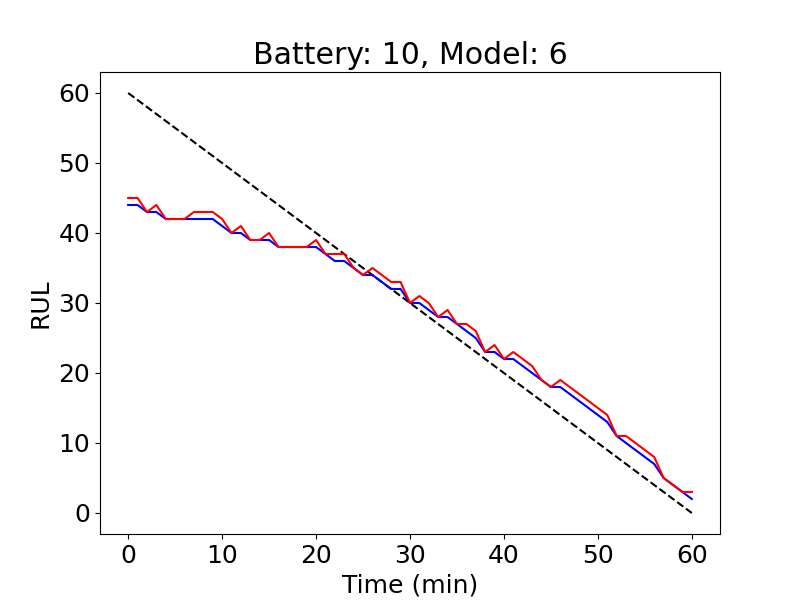

<IPython.core.display.Javascript object>


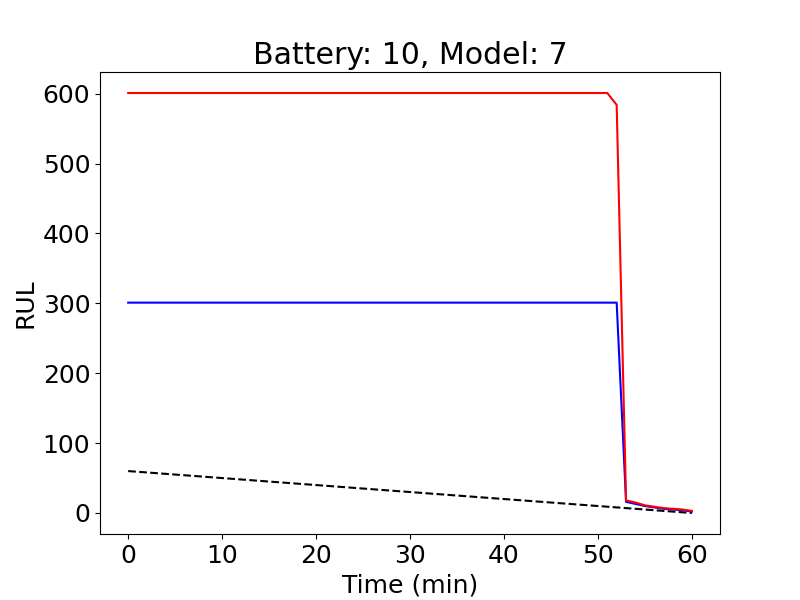

<IPython.core.display.Javascript object>


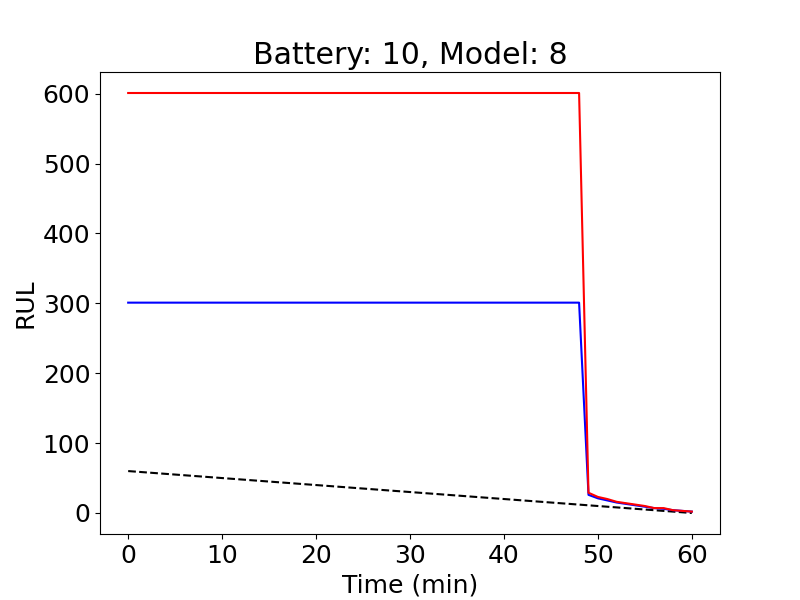

<IPython.core.display.Javascript object>


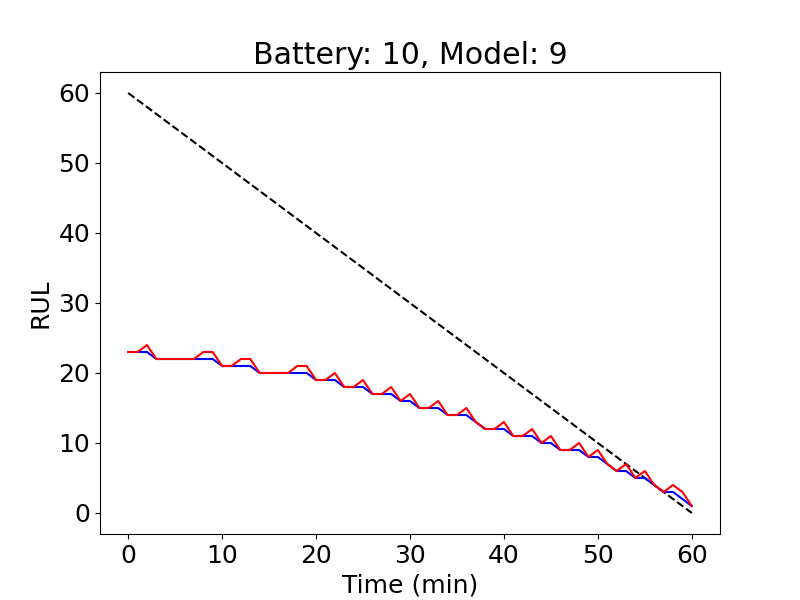

<IPython.core.display.Javascript object>


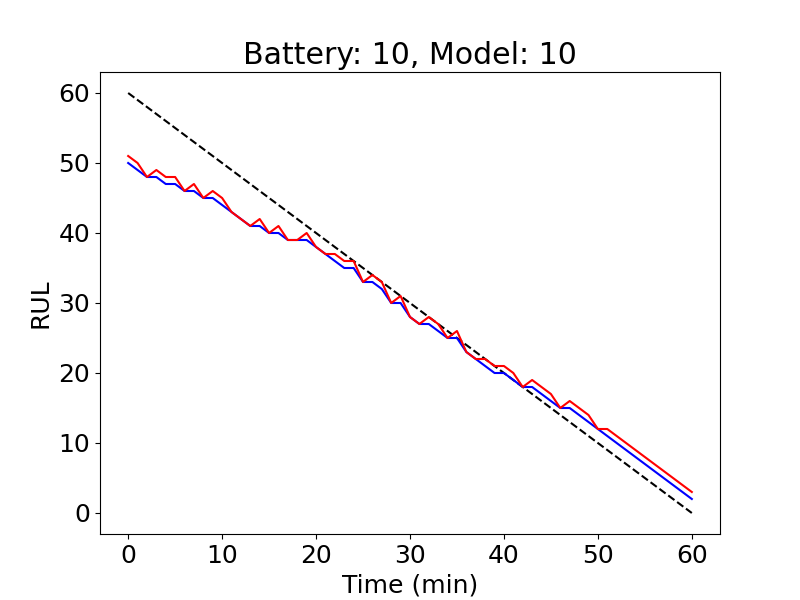

In [10]:
loaddata=loadmat('../Datasets/Training - 169 LFP.mat')
battery_HI = loaddata['ydata']
nbatteries = np.shape(battery_HI)[1]
cutoff = 0.2  # originally 0.8 but since we do HI = 1-capacity, cutoff is 0.2

FPT = loaddata['fpt_idxs']
EOL = loaddata['eol_idxs']

bid = 10  # a representative battery from the training set
for k in range(nmodels): #run through all the trained models
    allRUL=[]
    allsRUL=[]
    raw_seq = 1 - battery_HI[0,bid]
    X, Y = splitsequence(raw_seq[0,FPT[0][bid]-n_steps_in:EOL[0][bid]], n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], n_features))   #samples of length n_steps_in
    Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))   #next step prediction value
    myRUL=[]
    mys = []
    for i in range(len(X)): # through all the samples of this battery
        (predsarr,sigmasarr, RUL)=pred_model(X[i,:,0], prediction_fns[k], n_steps_in,n_features, cutoff)
        mys.append(RUL - np.argmax((predsarr + sigmasarr)>=cutoff) - 1)
        myRUL.append(RUL)
    allRUL.append(myRUL)
    allsRUL.append(mys)

    predrul1=np.array(allRUL[0])
    s1 = np.array(allsRUL[0])
    actRUL=np.linspace(len(predrul1)-1,0,len(predrul1))

    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8, 6))
    plt.plot(actRUL,'--k')
    plt.plot(predrul1,'b')
    plt.plot(predrul1+s1,'r')
    plt.xlabel('Time (min)')
    plt.ylabel('RUL')
    plt.title("Battery: "+  str(bid)+ ", Model: "+ str(k+1))

### Model selection:
As can be seen from Models 2,5,7,8 the forecast is not continuously increasing because of improper learning. We only choose models that have proper learning.

From inspection models 1, 4, 6, 10 seem to perform the best. Although this is just for this battery from the training, we can automate the same process for all the training batteries and arrive at the best RUL predicting models (based on the training dataset)

## determine RUL for training dataset + 3 test sets

In [12]:
loaddata=loadmat('../Datasets/Training - 169 LFP.mat')
battery_HI = loaddata['ydata']
nbatteries = np.shape(battery_HI)[1]
cutoff = 0.2

FPT = loaddata['fpt_idxs']
EOL = loaddata['eol_idxs']

ALLBP2=[]
ALLBS2=[]
for k in [0,3,5,9]:  # corresponding to models 1,4,6,10
    ALLBP=[]
    ALLBS=[]
    pbar=ProgressBar()

    for bid in pbar(range(nbatteries)):
        raw_seq = 1 - battery_HI[0,bid]
        if bid==20:
            X, Y = splitsequence(raw_seq[0,FPT[0][bid]-n_steps_in+1:EOL[0][bid]+1], n_steps_in, n_steps_out)
        else:
            X, Y = splitsequence(raw_seq[0,FPT[0][bid]-n_steps_in:EOL[0][bid]], n_steps_in, n_steps_out)
        X = X.reshape((X.shape[0], X.shape[1], n_features))   #samples of length n_steps_in
        Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))   #next step prediction value
        myRUL=[]
        mys = []
        for i in range(len(X)):
            (predsarr,sigmasarr, RUL)=pred_model(X[i,:,0], prediction_fns[k], n_steps_in,n_features, cutoff)
            mys.append(RUL - np.argmax((predsarr + sigmasarr)>=cutoff) - 1)
            myRUL.append(RUL)
        ALLBP.append(myRUL)
        ALLBS.append(mys)
    ALLBP2.append(ALLBP)
    ALLBS2.append(ALLBS)
savemat('LSTMBat0.mat', {'ALLBP2':ALLBP2, 'ALLBS2':ALLBS2})    

100% |#########################################################################|
100% |#########################################################################|
100% |#########################################################################|
100% |#########################################################################|
/home/venkat/anaconda3/envs/py3/lib/python3.10/site-packages/scipy/io/matlab/_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


In [13]:
loaddata=loadmat('../Datasets/Test1 - 169 LFP.mat')
battery_HI = loaddata['ydata']
nbatteries = np.shape(battery_HI)[1]
cutoff = 0.2

FPT = loaddata['fpt_idxs']
EOL = loaddata['eol_idxs']

ALLBP2=[]
ALLBS2=[]
for k in [0,3,5,9]:  # corresponding to models 1,4,6,10
    ALLBP=[]
    ALLBS=[]
    pbar=ProgressBar()

    for bid in pbar(range(nbatteries)):
        raw_seq = 1 - battery_HI[0,bid]
        X, Y = splitsequence(raw_seq[0,FPT[0][bid]-n_steps_in:EOL[0][bid]], n_steps_in, n_steps_out)
        X = X.reshape((X.shape[0], X.shape[1], n_features))   #samples of length n_steps_in
        Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))   #next step prediction value
        myRUL=[]
        mys = []
        for i in range(len(X)):
            (predsarr,sigmasarr, RUL)=pred_model(X[i,:,0], prediction_fns[k], n_steps_in,n_features, cutoff)
            mys.append(RUL - np.argmax((predsarr + sigmasarr)>=cutoff) - 1)
            myRUL.append(RUL)
        ALLBP.append(myRUL)
        ALLBS.append(mys)
    ALLBP2.append(ALLBP)
    ALLBS2.append(ALLBS)
savemat('LSTMBat1.mat', {'ALLBP2':ALLBP2, 'ALLBS2':ALLBS2})    

100% |#########################################################################|
100% |#########################################################################|
100% |#########################################################################|
100% |#########################################################################|


In [14]:
loaddata=loadmat('../Datasets/Test2 - 169 LFP.mat')
battery_HI = loaddata['ydata']
nbatteries = np.shape(battery_HI)[1]
cutoff = 0.2

FPT = loaddata['fpt_idxs']
EOL = loaddata['eol_idxs']

ALLBP2=[]
ALLBS2=[]
for k in [0,3,5,9]:  # corresponding to models 1,4,6,10
    ALLBP=[]
    ALLBS=[]
    pbar=ProgressBar()

    for bid in pbar(range(nbatteries)):
        raw_seq = 1 - battery_HI[0,bid]
        X, Y = splitsequence(raw_seq[0,FPT[0][bid]-n_steps_in:EOL[0][bid]], n_steps_in, n_steps_out)
        X = X.reshape((X.shape[0], X.shape[1], n_features))   #samples of length n_steps_in
        Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))   #next step prediction value
        myRUL=[]
        mys = []
        for i in range(len(X)):
            (predsarr,sigmasarr, RUL)=pred_model(X[i,:,0], prediction_fns[k], n_steps_in,n_features, cutoff)
            mys.append(RUL - np.argmax((predsarr + sigmasarr)>=cutoff) - 1)
            myRUL.append(RUL)
        ALLBP.append(myRUL)
        ALLBS.append(mys)
    ALLBP2.append(ALLBP)
    ALLBS2.append(ALLBS)
savemat('LSTMBat2.mat', {'ALLBP2':ALLBP2, 'ALLBS2':ALLBS2})    

100% |#########################################################################|
100% |#########################################################################|
100% |#########################################################################|
100% |#########################################################################|


In [15]:
loaddata=loadmat('../Datasets/Test3 - 169 LFP.mat')
battery_HI = loaddata['ydata']
nbatteries = np.shape(battery_HI)[1]
cutoff = 0.2

FPT = loaddata['fpt_idxs']
EOL = loaddata['eol_idxs']

ALLBP2=[]
ALLBS2=[]
for k in [0,3,5,9]:  # corresponding to models 1,4,6,10
    ALLBP=[]
    ALLBS=[]
    pbar=ProgressBar()

    for bid in pbar(range(nbatteries)):
        raw_seq = 1 - battery_HI[0,bid]
        X, Y = splitsequence(raw_seq[0,FPT[0][bid]-n_steps_in:EOL[0][bid]], n_steps_in, n_steps_out)
        X = X.reshape((X.shape[0], X.shape[1], n_features))   #samples of length n_steps_in
        Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))   #next step prediction value
        myRUL=[]
        mys = []
        for i in range(len(X)):
            (predsarr,sigmasarr, RUL)=pred_model(X[i,:,0], prediction_fns[k], n_steps_in,n_features, cutoff)
            mys.append(RUL - np.argmax((predsarr + sigmasarr)>=cutoff) - 1)
            myRUL.append(RUL)
        ALLBP.append(myRUL)
        ALLBS.append(mys)
    ALLBP2.append(ALLBP)
    ALLBS2.append(ALLBS)
savemat('LSTMBat3.mat', {'ALLBP2':ALLBP2, 'ALLBS2':ALLBS2})    

100% |#########################################################################|
100% |#########################################################################|
100% |#########################################################################|
100% |#########################################################################|
